In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn
from numpy import std
from numpy import mean
import matplotlib.pyplot as plt 
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score

1) import the data

In [3]:
trainData = pd.read_csv("/kaggle/input/titanic/train.csv")
testData = pd.read_csv("/kaggle/input/titanic/test.csv")

2) printing the first seven rows from the DataFrame

In [4]:
trainData.head(n=7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


3) some information about the dataset, the mean of the values for each column,count,max value, min value...

In [5]:
trainData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


4) showing the datatype of each column, and the columns that contains null values 

In [6]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


5) calculating the percentage of the survived passengers with Fare more than 50 and less than 50   

In [7]:
F1 = trainData.loc[trainData.Fare > 50]['Survived']
F1rate = sum(F1)/len(F1)
print("% of survived passengers with fare > 50 = ",F1rate*100,"%")

F2 = trainData.loc[trainData.Fare < 50]['Survived']
F2rate = sum(F2)/len(F2)
print("% of survived passengers with fare < 50 = ",F2rate*100,"%")


% of survived passengers with fare > 50 =  68.125 %
% of survived passengers with fare < 50 =  31.917808219178085 %


6) calculating the percentage of the first,second and third class survived passengers 

In [8]:
Aclass = trainData.loc[trainData.Pclass == 1]['Survived']
Arate = sum(Aclass)/len(Aclass)
print("% of first class survived passengers = ",Arate*100,"%")

Bclass = trainData.loc[trainData.Pclass == 2]['Survived']
Brate = sum(Bclass)/len(Bclass)
print("% of second class survived passengers = ",Brate*100,"%")

Cclass = trainData.loc[trainData.Pclass == 3]['Survived']
Crate = sum(Cclass)/len(Cclass)
print("% of third class survived passengers = ",Crate*100,"%")

% of first class survived passengers =  62.96296296296296 %
% of second class survived passengers =  47.28260869565217 %
% of third class survived passengers =  24.236252545824847 %


7) calculating the percentage of survived passengers with n siblings 

In [9]:
for s in range(0,6):
    ss = trainData.loc[trainData.SibSp == s]['Survived']
    rate = sum(ss)/len(ss)
    print("% of survived passengers with ",s," siblings = ",rate*100,"%")

% of survived passengers with  0  siblings =  34.53947368421053 %
% of survived passengers with  1  siblings =  53.588516746411486 %
% of survived passengers with  2  siblings =  46.42857142857143 %
% of survived passengers with  3  siblings =  25.0 %
% of survived passengers with  4  siblings =  16.666666666666664 %
% of survived passengers with  5  siblings =  0.0 %


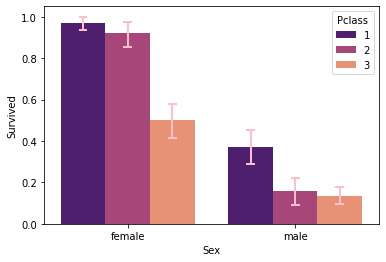

In [10]:
seaborn.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = trainData,palette = 'magma',
order = ['female', 'male'],capsize = 0.04,errcolor = 'pink', errwidth = 2)
plt.show()

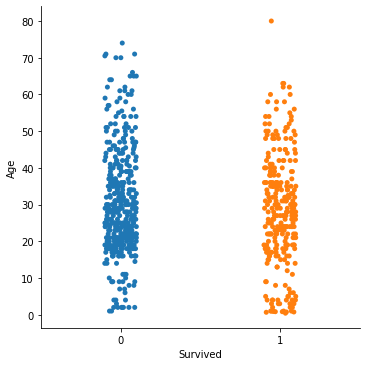

In [11]:
seaborn.catplot(x="Survived", y="Age", data=trainData)

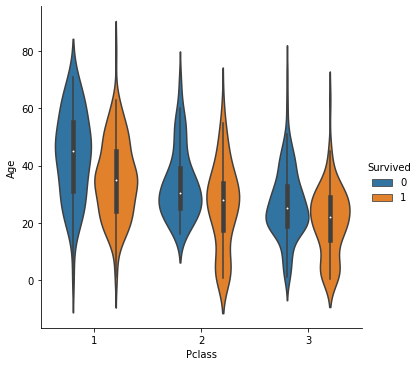

In [12]:
seaborn.catplot(x="Pclass", y="Age", hue = "Survived", kind = "violin", data=trainData)

Heatmap

<AxesSubplot:>

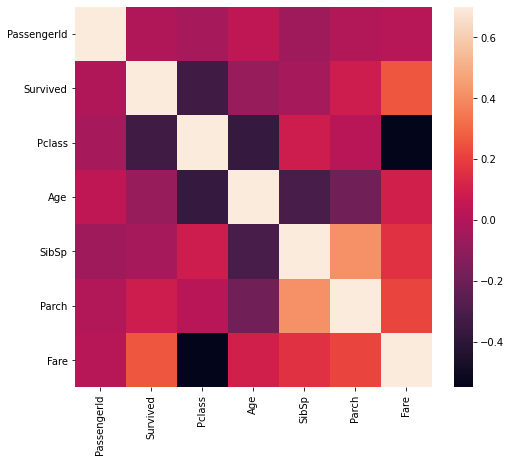

In [13]:
c = trainData.corr()
a, b = plt.subplots(figsize=(8, 7))
seaborn.heatmap(c, vmax = 0.7)

8) filling NaN values in 'Fare' and 'Age' columns

In [14]:
trainData['Fare'].fillna(trainData['Fare'].mean(), inplace=True)
testData['Fare'].fillna(testData['Fare'].mean(), inplace=True)

trainData['Age'].fillna(trainData['Age'].median(), inplace=True)
testData['Age'].fillna(testData['Age'].median(), inplace=True)

9) converting the categorical variables to dummy variables


In [15]:
j = trainData["Survived"]
f = ["Pclass","Age","SibSp","Parch","Fare"]
i = pd.get_dummies(trainData[f])
test = pd.get_dummies(testData[f])

10) using k-Fold Cross-Validation to evaluate the model,

    How it works:
    
     - spliting the dataset into k groups
     
     - for each one of the groups:
     
         - Taking the group as a test dataset
         
         - the remaining groups will be the training datasets 
         
         - fitting the model on the training set, and evaluating it on the test set
         
         - Retain the score 
         
     - calculating the accuracy using the sample scores

In [16]:
m = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 1)
m.fit(i,j)
prediction = m.predict(test)
output = pd.DataFrame({'PassengerId':testData.PassengerId,'Survived':prediction})
output.to_csv('my_submission.csv', index = False)

CrossValidation = RepeatedKFold(n_splits = 10, n_repeats = 5,random_state=1)
Score = cross_val_score(m,i,j,cv = CrossValidation )
print('accuracy = %.3f (%.3f)' % (mean(Score), std(Score)))
print("successful submission")

accuracy = 0.728 (0.041)
successful submission
